In [62]:
names_scraped2 = pd.read_csv("imdb_top_movies.csv")
names_scraped2

Unnamed: 0  rank  IMDB_id  \
0             0     1   111161   
1             0     2    68646   
2             0     3    71562   
3             0     4   468569   
4             0     5    50083   
..          ...   ...      ...   
245           0   246   169858   
246           0   247    66763   
247           0   248    56217   
248           0   249    87884   
249           0   250    50613   

                                         movie_name  year  \
0                          The Shawshank Redemption  1994   
1                                     The Godfather  1972   
2                            The Godfather: Part II  1974   
3                                   The Dark Knight  2008   
4                                      12 Angry Men  1957   
..                                              ...   ...   
245  Neon Genesis Evangelion: The End of Evangelion  1997   
246                                           Anand  1971   
247                The Man Who Shot Liberty Valance  1962   
248                                    Paris, Texas  1984   
249                                 Throne of Blood  1957   

                 director                                           starring  \
0          Frank Darabont    ['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']   
1    Francis Ford Coppola       ['Marlon Brando', 'Al Pacino', 'James Caan']   
2    Francis Ford Coppola   ['Al Pacino', 'Robert De Niro', 'Robert Duvall']   
3       Christopher Nolan  ['Christian Bale', 'Heath Ledger', 'Aaron Eckh...   
4            Sidney Lumet    ['Henry Fonda', 'Lee J. Cobb', 'Martin Balsam']   
..                    ...                                                ...   
245          Hideaki Anno  ['Megumi Ogata', 'Megumi Hayashibara', 'Yûko M...   
246  Hrishikesh Mukherjee  ['Rajesh Khanna', 'Amitabh Bachchan', 'Sumita ...   
247             John Ford      ['James Stewart', 'John Wayne', 'Vera Miles']   
248           Wim Wenders  ['Harry Dean Stanton', 'Nastassja Kinski', 'De...   
249        Akira Kurosawa  ['Toshirô Mifune', 'Minoru Chiaki', 'Isuzu Yam...   

     rating  number_of_reviews  \
0       9.3            2395380   
1       9.2            1659275   
2       9.0            1153451   
3       9.0            2357059   
4       9.0             706423   
..      ...                ...   
245     8.1              41717   
246     8.3              31743   
247     8.1              70294   
248     8.1              94983   
249     8.1              47807   

                                                genres  \
0                                            ['Drama']   
1                                   ['Crime', 'Drama']   
2                                   ['Crime', 'Drama']   
3             ['Action', 'Crime', 'Drama', 'Thriller']   
4                                   ['Crime', 'Drama']   
..                                                 ...   
245  ['Animation', 'Action', 'Drama', 'Fantasy', 'S...   
246                               ['Drama', 'Musical']   
247                               ['Drama', 'Western']   
248                                          ['Drama']   
249                               ['Drama', 'History']   

                                     country  \
0                                    ['USA']   
1                                    ['USA']   
2                                    ['USA']   
3                              ['USA', 'UK']   
4                                    ['USA']   
..                                       ...   
245                                ['Japan']   
246                                ['India']   
247                                  ['USA']   
248  ['West Germany', 'France', 'UK', 'USA']   
249                                ['Japan']   

                                              language        budget  \
0                                          ['English']   $25,000,000   
1                      ['English', 'Italian', 'Latin']    $6,000,000   
2  

       starring                        movie_name    Name  Gender  \
0           Tim          The Shawshank Redemption     Tim    male   
1           Tim                         Toy Story     Tim    male   
2           Tim                    Reservoir Dogs     Tim    male   
3           Tim                       Toy Story 3     Tim    male   
4           Tim  The Treasure of the Sierra Madre     Tim    male   
...         ...                               ...     ...     ...   
1049  Nastassja                      Paris, Texas     NaN     NaN   
1050       Dean                      Paris, Texas    Dean    male   
1051       Dean                      Paris, Texas    Dean  female   
1052     Minoru                   Throne of Blood  Minoru    male   
1053      Isuzu                   Throne of Blood     NaN     NaN   

      Gender_Dummy  
0                1  
1                1  
2                1  
3                1  
4                1  
...            ...  
1049             0  
105

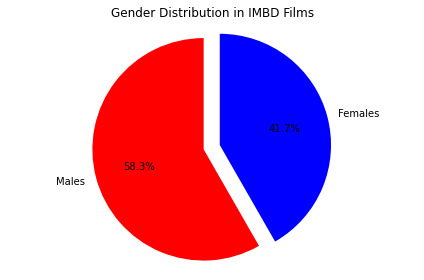

As the graph shows, almost 60% of the actors were males (as implied by their names)
This implies we do not have a perfect gender distribution in the scraped movies
Note that this is a dirty matching approach of names with genders based on our database


In [69]:
##-----------------------Analysis of gender diversity in the scraped movies--------------------------

## Importing all the necessary libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib3
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
import json
import urllib
import requests

#We get our data as a JSON database from "back4app"
#This database includes 250,000 different names and assigns wether they are for boys or girls

url = 'https://parseapi.back4app.com/classes/Complete_List_Names?limit=250000'
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I', 
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK' 
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) 

#Define the fields of interest and normalize data using "json_normalize"
FIELDS = ["Name", "Gender"]
name_database_all = pd.json_normalize(data["results"])
name_database = name_database_all[FIELDS]
#### We now have a datababase with 250 000 names and the repsective gender

#Loading CSV file with scraped data
names_scraped = pd.read_csv("imdb_top_movies.csv")
## using the pd.explode to create a new row for each actor
names_scraped_rows = names_scraped[["starring", "movie_name"]].assign( starring = names_scraped["starring"].str.split(", ")).explode("starring")
#Cleaning the row "starring" that contains the names
names_scraped_rows["starring"] = names_scraped_rows["starring"].str.split(" ", n = 1, expand = True)
names_scraped_rows["starring"] = names_scraped_rows["starring"].str.replace("[", "").str.replace("'","").str.replace("]", "").str.replace('"', "")

#Create an empty column to be filled
names_scraped_rows["Gender"] = ""

name_database = name_database.loc[:, ["Name", "Gender"]]
name_database = name_database.drop_duplicates()

#We use merge to match the names we scraped with the implied gender from our dataset
df = pd.merge(names_scraped_rows, name_database, how="outer", left_on="starring", right_on="Name")

#We now have now matched the names with the implied genders based on our database
#We now clean the dataframe
#Dropping the datapoints for which we have no data and uncessecary columns
df.dropna(subset = ["movie_name"], inplace=True)
del df['Gender_x']
df.rename(columns={'Gender_y': 'Gender'}, inplace=True)

## we add a dummy column indicating a 1 in case the actor is a man, 0 otherwise
df['Gender_Dummy'] = df.Gender.apply(lambda x: 1 if x == "male" else 0)

#We get the following dataframe
print(df)

#We count the number of males and female by distribution
df['Gender'].value_counts()
male_count =((df.Gender == 'male').sum())
female_count = ((df.Gender == 'female').sum())

#We plot a pie chart with the implied gender distribution of the actors/actresses in the movies we scraped
proportions = [male_count, female_count]
plt.pie(proportions,labels = ['Males', 'Females'],shadow = False, colors = ['red','blue'], explode = (0.15 , 0), startangle = 90,autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Gender Distribution in IMBD Films")
plt.tight_layout()
plt.show()

print("As the graph shows, almost 60% of the actors were males (as implied by their names)")
print("This implies we do not have a perfect gender distribution in the scraped movies")
print("Note that this is a dirty matching approach of names with genders based on our database")

#Of course, not all the names of the actors/actresses in our scraped movies are included in the database
#Also, some names can of course be applicable for both of the classical gender labels leading to distorted results


#----Calculating the male to female ratio per movie----

#We create a new column with a gender dummy if there is a male in the movie
df['Male_Dummy'] = df.Gender.apply(lambda x: 1 if x == "male" else 0)

#CalculatingMale ratio per movie

def Gender Ratio per movie
df['Gender_Ratio'] = 


In [ ]:
##-----------------------Analysis of gender diversity in the scraped movies--------------------------

## Importing all the necessary libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib3
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

#We get our data as a JSON database from "back4app"
url = 'https://parseapi.back4app.com/classes/Complete_List_Names?limit=250000'
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I', # This is the fake app's application id
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK' # This is the fake app's readonly master key
}
data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need

#Define the fields of interest and normalize data using "json_normalize"
FIELDS = ["Name", "Gender"]
name_database_all = pd.json_normalize(data["results"])

name_database = name_database_all[FIELDS]
####We now have a datababase with 250 000 names and the repsective gender

#Loading CSV file with scraped data
names_scraped = pd.read_csv("imdb_top_movies.csv")

## using the pd.explode to create a new row for each actor
names_scraped_rows = names_scraped[["starring", "movie_name"]].assign( starring = imdb_top_movies["starring"].str.split(", ")).explode("starring")

#Cleaning the row "starring" that contains the names
names_scraped_rows["starring"] = names_scraped_rows["starring"].str.split(" ", n = 1, expand = True)
names_scraped_rows["starring"] = names_scraped_rows["starring"].str.replace("[", "").str.replace("'","").str.replace("]", "").str.replace('"', "")
names_scraped_rows["Gender"] = ""

names = names.loc[:, ["name", "sex"]]
names = names.drop_duplicates()

df = pd.merge(names_scraped_rows, names, how="outer", left_on="starring", right_on="name")
df.loc[30:40,]


#We add a Gender column by matching the names in the database using lookup
name_database = name_database.set_index('Name')
names_scraped_rows['Gender'] = name_database.lookup(names_scraped_rows['Starring'],name_database["Gender"])





In [ ]:
names_scraped_rows["starring"]= names_scraped_rows["starring"].str.split("t", n = 1, expand = True)

#Set up for loop, we will compare the names we scraped with the names in the database and fill the lsit
for element in names_scraped_rows["starring"]:
    if element in names["name"]:
        names_scraped_rows["Gender"] = "


#I define a translation function

def translate(lst):
    #We define the dictionary - I added the word "friends" as a check
    dictionary = {"merry":"god", "christmas":"jul", "and":"och","happy":"gott", "new":"nytt", "year":"ar","friends":"vänner"}
    list_SWE = []
    #We fill up to empty list using a for and if loop that checks wether element is in the dictionary
    for element in lst:
        if element in dictionary:
            list_SWE.append(dictionary[element])
    return(" ".join(list_SWE))
#I return the words as a string, instead of a list, by appending the elements in the list

#We test the result
translate(['merry', 'christmas', 'and', 'happy', 'new', 'year', 'friends'])

gender = []
#Set up for loop, we will compare the names we scraped with the names in the database and fill the lsit
for  in names_scraped_rows["starring"]:
    if element in names["name"]:
        names_scraped_rows

gender


#Set up for loop, we will compare the names we scraped with the names in the database and fill the lsit
for element in names_scraped_rows["starring"]:
    if element in names["name"]:
        names_scraped_rows["Gender"] = ""

names_scraped_rows

In [1]:
import gender_guesser.detector as gender
d = gender.Detector()
print(d.get_gender(u"Bob"))
print(d.get_gender(u"Sally"))
print(d.get_gender(u"Pauley")) # should be androgynous
andy

ModuleNotFoundError: No module named 'gender_guesser'

In [44]:
dictionary = names.set_index('name').to_dict()['sex']
dictionary

import pandas as pd
df = pd.read_csv(filename,names=['code'])
df[['code','name_of_code']] = df["code"].str.split(" ", 1, expand=True)
df["name_of_code"] = df["name_of_code"].str.strip("-")
print(df)

{'John': 'girl',
 'William': 'girl',
 'James': 'girl',
 'Charles': 'girl',
 'George': 'girl',
 'Frank': 'girl',
 'Joseph': 'girl',
 'Thomas': 'girl',
 'Henry': 'girl',
 'Robert': 'girl',
 'Edward': 'girl',
 'Harry': 'girl',
 'Walter': 'girl',
 'Arthur': 'girl',
 'Fred': 'girl',
 'Albert': 'girl',
 'Samuel': 'boy',
 'David': 'girl',
 'Louis': 'girl',
 'Joe': 'girl',
 'Charlie': 'girl',
 'Clarence': 'girl',
 'Richard': 'girl',
 'Andrew': 'girl',
 'Daniel': 'girl',
 'Ernest': 'girl',
 'Will': 'girl',
 'Jesse': 'girl',
 'Oscar': 'boy',
 'Lewis': 'boy',
 'Peter': 'boy',
 'Benjamin': 'boy',
 'Frederick': 'boy',
 'Willie': 'girl',
 'Alfred': 'girl',
 'Sam': 'boy',
 'Roy': 'girl',
 'Herbert': 'boy',
 'Jacob': 'boy',
 'Tom': 'girl',
 'Elmer': 'girl',
 'Carl': 'girl',
 'Lee': 'girl',
 'Howard': 'girl',
 'Martin': 'boy',
 'Michael': 'girl',
 'Bert': 'girl',
 'Herman': 'boy',
 'Jim': 'boy',
 'Francis': 'girl',
 'Harvey': 'boy',
 'Earl': 'girl',
 'Eugene': 'girl',
 'Ralph': 'girl',
 'Ed': 'boy',
 '

In [55]:
#Loading CSV file with names
names = pd.read_csv("baby-names.csv")
len(names) #258 000 names
names.head()

#Setting up dictionary match female names with female and male names with male
dictionary = names.set_index('name').to_dict()
dictionary
#Loading CSV file with names
names = pd.read_csv("baby-names.csv")
len(names) #258 000 names
names.head()

#Setting up dictionary match female names with female and male names with male
dictionary = names.to_dict()["Name"]
dictionary

KeyError: 'Name'

In [118]:
names_scraped_rows

starring                movie_name Gender
0          Tim  The Shawshank Redemption       
0       Morgan  The Shawshank Redemption       
0          Bob  The Shawshank Redemption       
1       Marlon             The Godfather       
1           Al             The Godfather       
..         ...                       ...    ...
248  Nastassja              Paris, Texas       
248       Dean              Paris, Texas       
249    Toshirô           Throne of Blood       
249     Minoru           Throne of Blood       
249      Isuzu           Throne of Blood       

[750 rows x 3 columns]